# PDF Handling and Citations with AWS Bedrock

This notebook demonstrates how to work with PDFs and extract citations using Claude models on AWS Bedrock.

## Prerequisites

- AWS account with Bedrock access
- AWS credentials configured
- Required Python packages installed

In [1]:
# Install required packages
!pip install boto3 PyPDF2 PyMuPDF

## Understanding PDF Handling in Bedrock <a id="understanding-pdf-handling"></a>

### How PDF Handling Works

Amazon Bedrock's PDF handling capability allows Claude models to process PDF documents in Claude's native approach. Here's how it works:

1. **PDF Processing**: Claude's API layer translates the document into text extractions plus images of the pages
2. **Full Document Understanding**: Claude can see and understand:
   - Text content with preserved formatting
   - Document structure (headers, paragraphs, lists)
   - Tables and their relationships
   - Images and diagrams within the PDF
   - Page layout and organization

### Benefits Over Text Extraction

Traditional approaches often extract text from PDFs before sending to language models. Native PDF handling offers significant advantages:

#### 1. **Preserved Context and Layout**
- Maintains spatial relationships between elements
- Preserves table structures and formatting
- Retains connection between images and their captions
- Keeps headers, footers, and page numbers in context

#### 2. **Visual Understanding**
- Can interpret charts, graphs, and diagrams
- Understands visual hierarchies and emphasis
- Recognizes formatting cues (bold, italic, font sizes)
- Can reference specific page locations

#### 3. **Accurate Citations**
- Provides exact page numbers for references
- Can quote specific passages with their locations
- Maintains document integrity for compliance needs
- Enables precise source attribution

#### 4. **Reduced Preprocessing**
- No need for complex PDF parsing libraries
- Eliminates text extraction errors
- Handles complex layouts automatically
- Works with scanned documents (with good OCR)

#### 5. **Better Comprehension**
- Understands document flow and structure
- Can navigate between sections effectively
- Recognizes document types (reports, papers, forms)
- Maintains mathematical formulas and special characters

### When to Use PDF Handling

Native PDF handling is ideal for:
- Academic papers and research documents
- Legal documents requiring precise citations
- Technical manuals with diagrams
- Financial reports with complex tables
- Multi-column layouts
- Documents with mixed content types

## Setup and Configuration <a id="prerequisites"></a>

In [2]:
import json
import boto3
import base64
import io
import os
from botocore.config import Config
from botocore.exceptions import ClientError
from PyPDF2 import PdfReader, PdfWriter
from IPython.display import IFrame, display

# Configure the Bedrock client
def setup_bedrock_client(region='us-east-1'):
    """Setup Bedrock client with retry configuration"""
    config = Config(
        region_name=region,
        retries=dict(max_attempts=1000)
    )
    
    client = boto3.client(
        service_name='bedrock-runtime',
        config=config
    )
    
    return client

# Initialize the client
bedrock_client = setup_bedrock_client()
print("Bedrock client initialized successfully!")

Bedrock client initialized successfully!


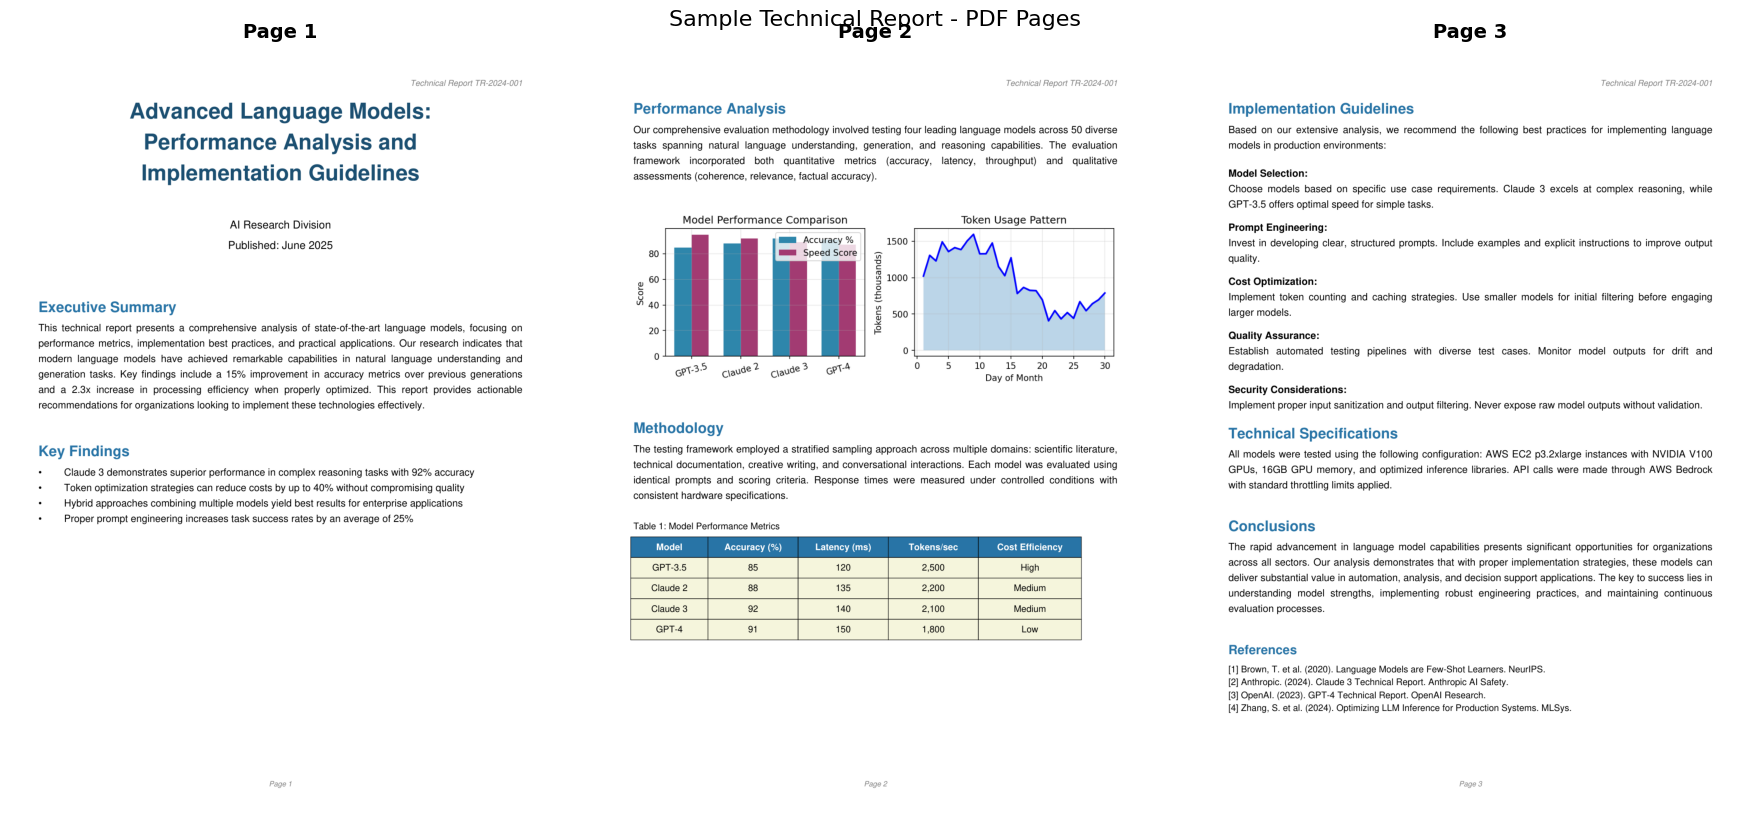

📄 PDF contains 3 pages total
✅ This PDF includes:
   - Text content with formatting
   - Charts and graphs (page 2)
   - Tables with data (page 2)
   - Multiple sections with headers


In [3]:
# Display the PDF pages
import pymupdf  # PyMuPDF
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def display_pdf_pages(pdf_path, max_pages=None):
    """Display all pages of a PDF as images"""
    try:
        # Open the PDF
        doc = pymupdf.open(pdf_path)
        num_pages = len(doc)
        
        if max_pages:
            num_pages = min(num_pages, max_pages)
        
        # Create figure with subplots
        fig, axes = plt.subplots(1, num_pages, figsize=(6*num_pages, 8))
        if num_pages == 1:
            axes = [axes]
        
        # Convert each page to image
        for i in range(num_pages):
            page = doc[i]
            pix = page.get_pixmap(matrix=pymupdf.Matrix(2, 2))  # 2x scaling for better quality
            img_data = pix.tobytes("png")
            img = Image.open(io.BytesIO(img_data))
            
            # Display the page
            axes[i].imshow(img)
            axes[i].set_title(f"Page {i+1}", fontsize=14, fontweight='bold')
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.suptitle("Sample Technical Report - PDF Pages", fontsize=16, y=1.02)
        plt.show()
        
        print(f"📄 PDF contains {len(doc)} pages total")
        print("✅ This PDF includes:")
        print("   - Text content with formatting")
        print("   - Charts and graphs (page 2)")
        print("   - Tables with data (page 2)")
        print("   - Multiple sections with headers")
        
    except ImportError:
        print("PyMuPDF not installed. Showing PDF info instead...")
        reader = PdfReader(pdf_path)
        print(f"📄 PDF contains {len(reader.pages)} pages")
        print("✅ This PDF includes:")
        print("   - Text content with formatting")
        print("   - Charts and graphs (page 2)")
        print("   - Tables with data (page 2)")
        print("   - Multiple sections with headers")
        print("\nTo view PDF pages, install PyMuPDF: pip install pymupdf")

# Display the sample PDF
display_pdf_pages("sample_technical_report.pdf")

## Sample PDF Overview

Let's first look at the sample PDF we'll be analyzing. This technical report contains charts, tables, and formatted text that demonstrates Claude's PDF handling capabilities:

## Quick Start: Simple PDF Analysis and Citations Examples

Before diving into the full implementation, let's start with simple, copy-paste ready examples showing both `invokeModel` and `converse` API calls with PDF handling, and an example of citations with `invokeModel`.

**Key Features Highlighted:**
- ✅ Native PDF processing without preprocessing
- ✅ Automatic prompt caching for repeated analyses
- ✅ Visual content understanding (charts, graphs, images)
- ✅ Precise citations with page numbers

In [4]:
# This example demonstrates prompt caching - subsequent calls will be faster!

import json
import boto3
import base64

# Read and encode the PDF
with open("sample_technical_report.pdf", "rb") as pdf_file:
    encoded_pdf = base64.b64encode(pdf_file.read()).decode("utf-8")

# Prepare the request with prompt caching enabled
request_body = {
    "anthropic_version": "bedrock-2023-05-31",
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "document",
                    "source": {
                        "type": "base64",
                        "media_type": "application/pdf",
                        "data": encoded_pdf
                    },
                    "title": "Technical Report",
                    "citations": {"enabled": True},
                    "cache_control": {"type": "ephemeral"}  # Enable prompt caching!
                },
                {
                    "type": "text",
                    "text": "What charts or graphs are shown in this document? Describe what you see in any visual elements."
                }
            ]
        }
    ],
    "max_tokens": 500
}

# Make the API call
response = bedrock_client.invoke_model(
    modelId="us.anthropic.claude-sonnet-4-20250514-v1:0",
    contentType='application/json',
    accept='application/json',
    body=json.dumps(request_body)
)

# Parse and display the response
response_body = json.loads(response['body'].read())
print("Claude's Analysis:")

for block in response_body.get('content', []):
    if block.get('type') == 'text':
        print(block.get('text', ''))

# Show metrics including cache information
usage = response_body.get('usage', {})
print(f"\nMetrics:")
print(f"  Input tokens: {usage.get('input_tokens', 0)}")
print(f"  Output tokens: {usage.get('output_tokens', 0)}")
if usage.get('cache_creation_input_tokens', 0) > 0:
    print(f"  🚀 Cache created with {usage.get('cache_creation_input_tokens', 0)} tokens!")
    print(f"  (Subsequent calls to this PDF will be faster and cheaper)")
if usage.get('cache_read_input_tokens', 0) > 0:
    print(f"  ⚡ Cache hit! Read {usage.get('cache_read_input_tokens', 0)} tokens from cache")

Claude's Analysis:
Based on the document, there are two charts/graphs shown on page 2:

## 1. Model Performance Comparison (Bar Chart)
This is a bar chart comparing four language models (GPT-3.5, Claude 2, Claude 3, and GPT-4) across two metrics:
- **Accuracy %** (shown in blue bars)
- **Speed Score** (shown in purple/magenta bars)

The chart shows scores on a scale from 0 to approximately 100, with 
Claude 3 achieving 92% accuracy
 as the highest performer in accuracy metrics.

## 2. Token Usage Pattern (Line Graph)
This is a line graph showing token usage over time, with:
- **X-axis**: Day of Month (0 to 30)
- **Y-axis**: Tokens (in thousands, ranging from 0 to 1500)
- **Blue line**: Shows token usage fluctuating over the course of a month

The pattern shows higher usage in the early part of the month (around 1500 tokens), dropping to lower levels in the middle (around 500 tokens), and then rising again toward the end of the month (around 750 tokens).

These visual elements support t

In [5]:
# IMPORTANT: To use Claude's PDF support with Converse, you MUST include the citations flag!

# Read the PDF as raw bytes (NOT base64 for Converse!)
with open("sample_technical_report.pdf", "rb") as pdf_file:
    pdf_bytes = pdf_file.read()

# Prepare the message
messages = [
    {
        "role": "user",
        "content": [
            {
                "document": {
                    "name": "Technical Report",
                    "format": "pdf",
                    "source": {
                        "bytes": pdf_bytes  # Raw bytes, not base64!
                    },
                    "citations": {"enabled": True}  # REQUIRED for Claude's PDF support in Converse!
                }
            },
            {
                "text": "What visual elements (charts, graphs, diagrams) are present in this document? Describe what they show."
            }
        ]
    }
]

# Make the converse call
response = bedrock_client.converse(
    modelId="us.anthropic.claude-sonnet-4-20250514-v1:0",
    messages=messages,
    inferenceConfig={
        "maxTokens": 500,
        "temperature": 0.5
    }
)

# Display the response
print("Claude's Analysis:")
output = response.get('output', {})

if 'message' in output:
    content = output['message'].get('content', [])
    for item in content:
        if 'text' in item:
            print(item['text'], end="")
        elif 'citationsContent' in item:
            print(f"'{item['citationsContent']['content'][0]['text']}'", end="")


# Show usage metrics
usage = response.get('usage', {})
print(f"\nMetrics:")
print(f"  Input tokens: {usage.get('inputTokens', 0)}")
print(f"  Output tokens: {usage.get('outputTokens', 0)}")
print(f"  Total tokens: {usage.get('totalTokens', 0)}")

Claude's Analysis:
Based on the document, there are two main visual elements present:

## 1. Model Performance Comparison Chart
This is a bar chart that displays comparative performance metrics for four language models (GPT-3.5, Claude 2, Claude 3, and GPT-4). The chart shows two metrics:
- **Accuracy %** (represented by one set of bars)
- **Speed Score** (represented by another set of bars)

The chart visually demonstrates that 'Claude 3 demonstrates superior performance in complex reasoning tasks with 92% accuracy', making it the highest-performing model in terms of accuracy among those tested.

## 2. Token Usage Pattern Graph
This is a line graph showing token usage patterns over time, with:
- **X-axis**: Day of Month (ranging from 0 to 30)
- **Y-axis**: Tokens (in thousands, ranging from 0 to 1500)
- **Data visualization**: A blue line showing fluctuating token usage patterns over a monthly period

The graph shows varying usage patterns with peaks around days 5-10 reaching approxim

## Extracting Citations with Invoke API

This example shows how to extract precise citations from documents:

In [6]:
import json
import boto3
import base64

# Read and encode the PDF
with open("sample_technical_report.pdf", "rb") as pdf_file:
    encoded_pdf = base64.b64encode(pdf_file.read()).decode("utf-8")

# Request with citations enabled
request_body = {
    "anthropic_version": "bedrock-2023-05-31",
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "document",
                    "source": {
                        "type": "base64",
                        "media_type": "application/pdf",
                        "data": encoded_pdf
                    },
                    "title": "Technical Report",
                    "citations": {"enabled": True}  # Enable citations
                },
                {
                    "type": "text",
                    "text": "What are the key findings about model performance? Please cite specific numbers."
                }
            ]
        }
    ],
    "max_tokens": 500
}

# Make the API call
response = bedrock_client.invoke_model(
    modelId="us.anthropic.claude-sonnet-4-20250514-v1:0",
    contentType='application/json',
    accept='application/json',
    body=json.dumps(request_body)
)

response_body = json.loads(response['body'].read())

# Display response with citations
print("Key Findings:")
for block in response_body.get('content', []):
    if block.get('type') == 'text':
        print(block.get('text', ''))
    
    # Extract citations if present
    if block.get('citations'):
        print("\n📍 Citations:")
        for citation in block.get('citations', []):
            print(f"- \"{citation.get('cited_text', '')}\"")
            print(f"  Source: {citation.get('document_title', '')}, Pages {citation.get('start_page_number', 'N/A')}-{citation.get('end_page_number', 'N/A')}")

Key Findings:
Based on the technical report, here are the key findings about model performance with specific numbers:

## Overall Performance Improvements

Modern language models show a 15% improvement in accuracy metrics over previous generations and a 2.3x increase in processing efficiency when properly optimized.

📍 Citations:
- "Key findings include a 15% improvement in accuracy metrics over previous generations
and a 2.3x increase in processing efficiency when properly optimized. "
  Source: Technical Report, Pages 1-2


## Individual Model Performance

Claude 3 demonstrates superior performance in complex reasoning tasks with 92% accuracy

📍 Citations:
- "Key Findings
• Claude 3 demonstrates superior performance in complex reasoning tasks with 92% accuracy
• Token optimization strategies can reduce costs by up to 40% without compromising quality
• Hybrid approaches combining multiple models yield best results for enterprise applications
• Proper prompt engineering increases task 

## Key API Differences: Invoke vs Converse

### InvokeModel API
- **Purpose**: Direct model invocation with full control over request format
- **PDF Encoding**: Requires base64-encoded PDF data
- **Citations**: Optional (works without citations flag)
- **Caching**: Use `cache_control` directly on document
- **Use when**: You need maximum control and all features

### Converse API
- **Purpose**: Simplified conversational interface
- **PDF Encoding**: Requires raw PDF bytes (NOT base64!)
- **Citations**: REQUIRED - must include `"citations": {"enabled": True}` to use Claude's PDF support
- **Caching**: Must use separate cache point elements (cannot cache directly in document block)
- **Use when**: You want simplified multi-turn conversations

### Critical Notes:
1. **Converse API PDF Limitation**: Without the citations flag, Converse uses its native PDF handler which may not provide the same quality as Claude's PDF support
2. **The most common errors**:
   - Converse: Passing base64 data instead of raw bytes
   - Converse: Forgetting the citations flag
   - Both: Exceeding the request size limit

## Basic PDF Processing Functions <a id="basic-pdf-processing"></a>

In [7]:
def encode_pdf(pdf_path):
    """Encode a PDF file to base64"""
    with open(pdf_path, "rb") as pdf_file:
        encoded_pdf = base64.b64encode(pdf_file.read()).decode("utf-8")
    return encoded_pdf

def encode_pdf_from_bytes(pdf_bytes):
    """Encode PDF bytes to base64"""
    return base64.b64encode(pdf_bytes).decode("utf-8")

def extract_pdf_pages(pdf_path, start_page=0, end_page=None):
    """Extract specific pages from a PDF"""
    reader = PdfReader(pdf_path)
    writer = PdfWriter()
    
    total_pages = len(reader.pages)
    end_page = end_page or total_pages
    
    for i in range(start_page, min(end_page, total_pages)):
        writer.add_page(reader.pages[i])
    
    output_buffer = io.BytesIO()
    writer.write(output_buffer)
    output_buffer.seek(0)
    
    return output_buffer.getvalue()

print("PDF processing functions loaded!")

PDF processing functions loaded!


### Metrics Helper Function

In [8]:
# Utility function for displaying metrics
def display_metrics(response_body, description=""):
    """Display usage metrics including prompt caching information"""
    usage = response_body.get('usage', {})
    
    print(f"\n{description} Metrics:")
    print(f"  Input tokens: {usage.get('input_tokens', 0)}")
    print(f"  Output tokens: {usage.get('output_tokens', 0)}")
    print(f"  Total tokens: {usage.get('input_tokens', 0) + usage.get('output_tokens', 0)}")
    
    # Check for prompt caching metrics
    cache_creation_input_tokens = usage.get('cache_creation_input_tokens', 0)
    cache_read_input_tokens = usage.get('cache_read_input_tokens', 0)
    
    if cache_creation_input_tokens > 0:
        print(f"  Cache creation tokens: {cache_creation_input_tokens}")
    if cache_read_input_tokens > 0:
        print(f"  Cache read tokens: {cache_read_input_tokens}")
        print(f"  Cache hit rate: {cache_read_input_tokens / usage.get('input_tokens', 1) * 100:.1f}%")

### Simple PDF Analysis

In [9]:
def analyze_pdf(pdf_path, question, max_tokens=1024):
    """Analyze a PDF with a specific question and track metrics"""
    encoded_pdf = encode_pdf(pdf_path)
    
    request_body = {
        "anthropic_version": "bedrock-2023-05-31",
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "document",
                        "source": {
                            "type": "base64",
                            "media_type": "application/pdf",
                            "data": encoded_pdf
                        },
                        "title": "Technical Report"
                    },
                    {
                        "type": "text",
                        "text": question
                    }
                ]
            }
        ],
        "max_tokens": max_tokens
    }
    
    response = bedrock_client.invoke_model(
        modelId="us.anthropic.claude-sonnet-4-20250514-v1:0",
        contentType='application/json',
        accept='application/json',
        body=json.dumps(request_body)
    )
    
    response_body = json.loads(response['body'].read())
    
    # Display metrics inline
    display_metrics(response_body, "PDF Analysis")
    
    return response_body

## Working with Citations <a id="citations"></a>

In [10]:
def analyze_pdf_with_citations(pdf_path, question, max_tokens=1024):
    """Analyze a PDF and extract citations with metrics tracking"""
    encoded_pdf = encode_pdf(pdf_path)
    
    request_body = {
        "anthropic_version": "bedrock-2023-05-31",
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "document",
                        "source": {
                            "type": "base64",
                            "media_type": "application/pdf",
                            "data": encoded_pdf
                        },
                        "title": "Technical Report",
                        "citations": {
                            "enabled": True
                        }
                    },
                    {
                        "type": "text",
                        "text": question
                    }
                ]
            }
        ],
        "max_tokens": max_tokens
    }
    
    response = bedrock_client.invoke_model(
        modelId="us.anthropic.claude-sonnet-4-20250514-v1:0",
        contentType='application/json',
        accept='application/json',
        body=json.dumps(request_body)
    )
    
    response_body = json.loads(response['body'].read())
    
    # Display metrics
    display_metrics(response_body, "Citations Analysis")
    
    return response_body

def format_citations(content):
    """Extract and format citations from response"""
    citations = []
    for block in content:
        if block.get('citations'):
            for citation in block.get('citations', []):
                citations.append({
                    'text': citation.get('cited_text', ''),
                    'document': citation.get('document_title', ''),
                    'start_page': citation.get('start_page_number', 'N/A'),
                    'end_page': citation.get('end_page_number', 'N/A')
                })
    return citations

def display_response_with_citations(response):
    """Display the response text and citations"""
    if not response:
        return
    
    # Extract main text
    full_text = ""
    for block in response.get('content', []):
        if block.get('type') == 'text':
            full_text += block.get('text', '')
    
    print("Response:")
    print(full_text)
    print("\n" + "="*50 + "\n")
    
    # Extract and display citations
    citations = format_citations(response.get('content', []))
    if citations:
        print("Citations:")
        for i, citation in enumerate(citations, 1):
            print(f"\n[{i}] \"{citation['text']}\"")
            print(f"    Source: {citation['document']}")
            print(f"    Pages: {citation['start_page']}-{citation['end_page']}")
    else:
        print("No citations found.")

print("Citation functions loaded!")

Citation functions loaded!


### Working with Text Documents

In [11]:
def analyze_text_with_citations(text_content, question, title="Document", max_tokens=1024):
    """Analyze text content and extract citations with metrics"""
    
    request_body = {
        "anthropic_version": "bedrock-2023-05-31",
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "document",
                        "source": {
                            "type": "text",
                            "media_type": "text/plain",
                            "data": text_content
                        },
                        "title": title,
                        "citations": {
                            "enabled": True
                        }
                    },
                    {
                        "type": "text",
                        "text": question
                    }
                ]
            }
        ],
        "max_tokens": max_tokens
    }
    
    response = bedrock_client.invoke_model(
        modelId="us.anthropic.claude-sonnet-4-20250514-v1:0",
        contentType='application/json',
        accept='application/json',
        body=json.dumps(request_body)
    )
    
    response_body = json.loads(response['body'].read())
    
    # Display metrics
    display_metrics(response_body, "Text Analysis with Citations")
    
    return response_body

### Streaming Responses

In [12]:
def stream_pdf_analysis(pdf_path, question, max_tokens=1024):
    """Stream the analysis of a PDF with metrics tracking"""
    encoded_pdf = encode_pdf(pdf_path)
    
    request_body = {
        "anthropic_version": "bedrock-2023-05-31",
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "document",
                        "source": {
                            "type": "base64",
                            "media_type": "application/pdf",
                            "data": encoded_pdf
                        },
                        "title": "Technical Report"
                    },
                    {
                        "type": "text",
                        "text": question
                    }
                ]
            }
        ],
        "max_tokens": max_tokens
    }
    
    try:
        response = bedrock_client.invoke_model_with_response_stream(
            modelId="us.anthropic.claude-sonnet-4-20250514-v1:0",
            contentType='application/json',
            accept='application/json',
            body=json.dumps(request_body)
        )
        
        # Process the stream and collect metrics
        full_response = ""
        metrics = {}
        
        for event in response.get('body'):
            chunk = event.get('chunk')
            if chunk:
                chunk_data = json.loads(chunk.get('bytes').decode())
                
                # Collect text
                if chunk_data.get('type') == 'content_block_delta':
                    delta = chunk_data.get('delta', {})
                    if delta.get('type') == 'text_delta':
                        text = delta.get('text', '')
                        full_response += text
                        print(text, end='', flush=True)
                
                # Collect metrics from message_stop event
                elif chunk_data.get('type') == 'message_stop':
                    if 'amazon-bedrock-invocationMetrics' in chunk_data:
                        bedrock_metrics = chunk_data['amazon-bedrock-invocationMetrics']
                        metrics['inputTokens'] = bedrock_metrics.get('inputTokenCount', 0)
                        metrics['outputTokens'] = bedrock_metrics.get('outputTokenCount', 0)
                        metrics['totalTokens'] = metrics['inputTokens'] + metrics['outputTokens']
                        
                        # Check for cache metrics
                        if 'cacheCreationInputTokenCount' in bedrock_metrics:
                            metrics['cacheCreationTokens'] = bedrock_metrics['cacheCreationInputTokenCount']
                        if 'cacheReadInputTokenCount' in bedrock_metrics:
                            metrics['cacheReadTokens'] = bedrock_metrics['cacheReadInputTokenCount']
        
        # Display metrics after streaming
        print("\n\nStreaming Metrics:")
        print(f"  Input tokens: {metrics.get('inputTokens', 'N/A')}")
        print(f"  Output tokens: {metrics.get('outputTokens', 'N/A')}")
        print(f"  Total tokens: {metrics.get('totalTokens', 'N/A')}")
        
        if 'cacheCreationTokens' in metrics:
            print(f"  Cache creation tokens: {metrics['cacheCreationTokens']}")
        if 'cacheReadTokens' in metrics:
            print(f"  Cache read tokens: {metrics['cacheReadTokens']}")
            if metrics.get('inputTokens', 0) > 0:
                print(f"  Cache hit rate: {metrics['cacheReadTokens'] / metrics['inputTokens'] * 100:.1f}%")
        
        return full_response
    
    except ClientError as e:
        print(f"Error: {e.response['Error']['Code']} - {e.response['Error']['Message']}")
        return None

print("Streaming function loaded!")

Streaming function loaded!


### Some wrap over functionality

In [13]:
def create_document_qa_system(pdf_path):
    """Create a Q&A system for a document with metrics tracking"""
    
    def ask_question(question):
        response = analyze_pdf_with_citations(pdf_path, question)
        display_response_with_citations(response)
        return response
    
    return ask_question

def analyze_research_paper(pdf_path):
    """Analyze a research paper with predefined questions and cumulative metrics"""
    
    questions = [
        "What is the main research question or hypothesis?",
        "What methodology was used in this research?",
        "What are the key findings or results?",
        "What limitations are mentioned?",
        "What are the future research directions suggested?"
    ]
    
    results = {}
    cumulative_metrics = {
        'total_input_tokens': 0,
        'total_output_tokens': 0,
        'total_cache_creation_tokens': 0,
        'total_cache_read_tokens': 0,
        'calls_with_cache_hits': 0
    }
    
    for i, question in enumerate(questions, 1):
        print(f"\n{'='*60}")
        print(f"Question {i}/{len(questions)}: {question}")
        print(f"{'='*60}\n")
        
        response = analyze_pdf_with_citations(pdf_path, question)
        display_response_with_citations(response)
        
        # Update cumulative metrics
        if response:
            usage = response.get('usage', {})
            cumulative_metrics['total_input_tokens'] += usage.get('input_tokens', 0)
            cumulative_metrics['total_output_tokens'] += usage.get('output_tokens', 0)
            cumulative_metrics['total_cache_creation_tokens'] += usage.get('cache_creation_input_tokens', 0)
            cumulative_metrics['total_cache_read_tokens'] += usage.get('cache_read_input_tokens', 0)
            
            if usage.get('cache_read_input_tokens', 0) > 0:
                cumulative_metrics['calls_with_cache_hits'] += 1
        
        results[question] = response
    
    # Display cumulative metrics
    print("\n" + "="*60)
    print("CUMULATIVE METRICS SUMMARY")
    print("="*60)
    print(f"Total API calls: {len(questions)}")
    print(f"Total input tokens: {cumulative_metrics['total_input_tokens']:,}")
    print(f"Total output tokens: {cumulative_metrics['total_output_tokens']:,}")
    print(f"Total tokens: {cumulative_metrics['total_input_tokens'] + cumulative_metrics['total_output_tokens']:,}")
    
    if cumulative_metrics['total_cache_creation_tokens'] > 0:
        print(f"\nPrompt Caching Statistics:")
        print(f"  Cache creation tokens: {cumulative_metrics['total_cache_creation_tokens']:,}")
        print(f"  Cache read tokens: {cumulative_metrics['total_cache_read_tokens']:,}")
        print(f"  Calls with cache hits: {cumulative_metrics['calls_with_cache_hits']}/{len(questions)}")
        
        if cumulative_metrics['total_cache_read_tokens'] > 0:
            cache_efficiency = (cumulative_metrics['total_cache_read_tokens'] / 
                              cumulative_metrics['total_input_tokens'] * 100)
            print(f"  Overall cache efficiency: {cache_efficiency:.1f}%")
            
            # Calculate token savings
            tokens_saved = cumulative_metrics['total_cache_read_tokens'] * 0.9  # 90% discount on cached tokens
            print(f"  Estimated tokens saved: {int(tokens_saved):,}")
    
    return results

### Example 1: Basic PDF Analysis

Let's start with a simple question about the document:

In [14]:
# Basic analysis without citations
print("Analyzing the PDF without citations...")
pdf_path = './sample_technical_report.pdf'
response = analyze_pdf(pdf_path, "What is the main topic of this document?")

if response:
    for block in response.get('content', []):
        if block.get('type') == 'text':
            print(block.get('text', ''))

Analyzing the PDF without citations...

PDF Analysis Metrics:
  Input tokens: 5635
  Output tokens: 177
  Total tokens: 5812
The main topic of this document is **Advanced Language Models: Performance Analysis and Implementation Guidelines**. 

This technical report provides a comprehensive analysis of state-of-the-art language models, specifically focusing on:

1. **Performance evaluation** - comparing four leading language models (GPT-3.5, Claude 2, Claude 3, and GPT-4) across 50 diverse tasks
2. **Implementation best practices** - providing actionable recommendations for organizations looking to deploy these technologies effectively
3. **Practical applications** - discussing how to optimize these models for enterprise use

The document presents quantitative performance metrics, cost optimization strategies, and practical guidelines for implementing language models in production environments. It's aimed at helping organizations understand how to effectively select, deploy, and manage 

### Example 2: Extracting Key Findings with Citations

Now let's use the citation feature to get precise references:

In [15]:
# Analysis with citations
print("Extracting key findings with citations...")
response = analyze_pdf_with_citations(pdf_path, "What are the key findings mentioned in this report?")
display_response_with_citations(response)

Extracting key findings with citations...

Citations Analysis Metrics:
  Input tokens: 6807
  Output tokens: 156
  Total tokens: 6963
Response:
Based on the technical report, the key findings are:

• Claude 3 demonstrates superior performance in complex reasoning tasks with 92% accuracy
• Token optimization strategies can reduce costs by up to 40% without compromising quality
• Hybrid approaches combining multiple models yield best results for enterprise applications
• Proper prompt engineering increases task success rates by an average of 25%

Additionally, the report highlights broader performance improvements in modern language models, including a 15% improvement in accuracy metrics over previous generations and a 2.3x increase in processing efficiency when properly optimized.


Citations:

[1] "Key Findings
• Claude 3 demonstrates superior performance in complex reasoning tasks with 92% accuracy
• Token optimization strategies can reduce costs by up to 40% without compromising qual

### Example 3: Understanding Visual Content

PDFs often contain charts and graphs. Let's ask about the visual content:

In [16]:
# Analyzing visual content
print("Analyzing charts and visual data...")
response = analyze_pdf_with_citations(
    pdf_path, 
    "Describe any charts or graphs in the document and what they show. What insights do they provide?"
)
display_response_with_citations(response)

Analyzing charts and visual data...

Citations Analysis Metrics:
  Input tokens: 6817
  Output tokens: 442
  Total tokens: 7259
Response:
The document contains two charts that provide insights into language model performance:

## Chart 1: Model Performance Comparison
This is a bar chart comparing four language models (GPT-3.5, Claude 2, Claude 3, and GPT-4) across two metrics:
- **Accuracy %** (shown in blue bars)
- **Speed Score** (shown in purple/magenta bars)

**Key insights:**
- Claude 3 achieves the highest accuracy at 92%, followed closely by GPT-4 at 91%
- GPT-3.5 has the lowest accuracy but appears to have competitive speed
- All models show relatively similar speed scores, with values appearing to be in the 80-90 range
- There's a general trade-off pattern where higher accuracy models don't necessarily have the highest speed scores

## Chart 2: Token Usage Pattern
This is a line graph showing token usage over a 30-day period, with:
- **X-axis:** Day of Month (0-30)
- **Y-axis:

### Example 4: Analyzing Tables

Let's extract and understand table data from the PDF:

In [17]:
# Analyzing table data
print("Extracting and analyzing table information...")
response = analyze_pdf_with_citations(
    pdf_path, 
    "What tables are in this document? Extract the performance metrics table and explain what it shows."
)
display_response_with_citations(response)

Extracting and analyzing table information...

Citations Analysis Metrics:
  Input tokens: 6815
  Output tokens: 524
  Total tokens: 7339
Response:
Based on my review of the document, there is one table present:

**Table 1: Model Performance Metrics** (found on page 2)

Here is the extracted table:

| Model | Accuracy (%) | Latency (ms) | Tokens/sec | Cost Efficiency |
|-------|--------------|--------------|------------|-----------------|
| GPT-3.5 | 85 | 120 | 2,500 | High |
| Claude 2 | 88 | 135 | 2,200 | Medium |
| Claude 3 | 92 | 140 | 2,100 | Medium |
| GPT-4 | 91 | 150 | 1,800 | Low |

## What the table shows:

This performance metrics table compares four leading language models across several key dimensions:

1. **Accuracy (%)**: Claude 3 demonstrates the highest accuracy at 92%, followed by GPT-4 at 91%, Claude 2 at 88%, and GPT-3.5 at 85%.

2. **Latency (ms)**: Response time measurements showing GPT-3.5 has the fastest response time at 120ms, while GPT-4 is the slowest at 150m

### Example 5: Creating a Document Q&A System

Let's create an interactive Q&A system for our technical report:

In [18]:
# Create a Q&A system for the technical report
qa_system = create_document_qa_system(pdf_path)

# Ask various questions
questions = [
    "What are the implementation guidelines mentioned?",
    "What models are compared in this report?",
    "What are the conclusions about language model capabilities?"
]

for question in questions:
    print(f"\n{'='*60}")
    print(f"Question: {question}")
    print(f"{'='*60}\n")
    qa_system(question)
    print("\n")


Question: What are the implementation guidelines mentioned?


Citations Analysis Metrics:
  Input tokens: 6804
  Output tokens: 416
  Total tokens: 7220
Response:
Based on the technical report, here are the implementation guidelines for deploying language models in production environments:

## Model Selection
Choose models based on specific use case requirements. Claude 3 excels at complex reasoning, while GPT-3.5 offers optimal speed for simple tasks.

## Prompt Engineering
Invest in developing clear, structured prompts. Include examples and explicit instructions to improve output quality.

## Cost Optimization
Implement token counting and caching strategies. Use smaller models for initial filtering before engaging larger models.

## Quality Assurance
Establish automated testing pipelines with diverse test cases. Monitor model outputs for drift and degradation.

## Security Considerations
Implement proper input sanitization and output filtering. Never expose raw model outputs without

### Example 6: Comprehensive Research Paper Analysis

Let's perform a full analysis of the document as if it were a research paper:

In [19]:
# Comprehensive analysis
print("Performing comprehensive document analysis...")
print("This will analyze the document from multiple perspectives...\n")

# Note: This might take a moment as it makes multiple API calls
results = analyze_research_paper(pdf_path)

Performing comprehensive document analysis...
This will analyze the document from multiple perspectives...


Question 1/5: What is the main research question or hypothesis?


Citations Analysis Metrics:
  Input tokens: 6806
  Output tokens: 325
  Total tokens: 7131
Response:
Based on the technical report provided, there isn't an explicitly stated research question or hypothesis in the traditional academic sense. However, the main research focus can be inferred from the report's purpose and methodology.

The primary research objective appears to be: **To comprehensively evaluate and compare the performance of state-of-the-art language models to provide actionable implementation guidelines for organizations.**

More specifically, the research aims to:

1. Present a comprehensive analysis of state-of-the-art language models, focusing on performance metrics, implementation best practices, and practical applications

2. Test four leading language models across 50 diverse tasks spanning natu

### Example 7: Streaming Response for Better UX

For long analyses, streaming provides immediate feedback:

In [20]:
# Streaming analysis for real-time feedback
print("Streaming analysis of the document...\n")
print("Summary: ", end="")
summary = stream_pdf_analysis(
    pdf_path, 
    "Provide a comprehensive summary of this technical report, including all major sections."
)
print("\n\nStreaming complete!")

Streaming analysis of the document...

Summary: # Technical Report TR-2024-001: Advanced Language Models Summary

## Overview
This comprehensive technical report from the AI Research Division (published June 2025) analyzes state-of-the-art language models, focusing on performance metrics, implementation strategies, and practical applications for organizations.

## Executive Summary & Key Findings

The research demonstrates significant advancement in language model capabilities:
- **15% improvement** in accuracy metrics over previous generations
- **2.3x increase** in processing efficiency when properly optimized
- **Claude 3** leads with **92% accuracy** in complex reasoning tasks
- **Token optimization** can reduce costs by up to **40%** without quality loss
- **Hybrid approaches** combining multiple models yield optimal enterprise results
- **Proper prompt engineering** increases task success rates by **25%**

## Performance Analysis

### Methodology
The evaluation tested four leadin

## Advanced Techniques <a id="advanced"></a>

### Comparing Converse API: With vs Without Citations Flag

Let's demonstrate the critical difference between using Converse API with and without the citations flag. This shows why the citations flag is REQUIRED for Claude's full PDF support:

In [21]:
# Compare Converse API with and without citations flag
print("=== COMPARISON: Converse API Citations Flag Impact ===\n")

# Read the PDF once
with open(pdf_path, "rb") as pdf_file:
    pdf_bytes = pdf_file.read()

# Test 1: WITHOUT citations flag (uses Converse's native PDF handler)
print("1. Converse API WITHOUT citations flag (native handler):")
print("-" * 50)

messages_without_citations = [
    {
        "role": "user",
        "content": [
            {
                "document": {
                    "name": "Technical Report",
                    "format": "pdf",
                    "source": {
                        "bytes": pdf_bytes
                    }
                    # NO citations flag - uses Converse's native PDF handler
                }
            },
            {
                "text": "What charts or visual elements are shown in this document? Describe the specific data points you can see."
            }
        ]
    }
]

try:
    response1 = bedrock_client.converse(
        modelId="us.anthropic.claude-sonnet-4-20250514-v1:0",
        messages=messages_without_citations,
        inferenceConfig={"maxTokens": 300, "temperature": 0.5}
    )
    
    output1 = response1.get('output', {})
    if 'message' in output1:
        content = output1['message'].get('content', [])
        for item in content:
            if 'text' in item:
                print(item['text'])
    
    usage1 = response1.get('usage', {})
    print(f"\nTokens used: {usage1.get('inputTokens', 0)}")
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")

# Test 2: WITH citations flag (uses Claude's PDF support)
print("2. Converse API WITH citations flag (Claude's PDF support):")
print("-" * 50)

messages_with_citations = [
    {
        "role": "user",
        "content": [
            {
                "document": {
                    "name": "Technical Report",
                    "format": "pdf",
                    "source": {
                        "bytes": pdf_bytes
                    },
                    "citations": {"enabled": True}  # ENABLES Claude's PDF support!
                }
            },
            {
                "text": "What charts or visual elements are shown in this document? Describe the specific data points you can see."
            }
        ]
    }
]

try:
    response2 = bedrock_client.converse(
        modelId="us.anthropic.claude-sonnet-4-20250514-v1:0",
        messages=messages_with_citations,
        inferenceConfig={"maxTokens": 300, "temperature": 0.5}
    )
    
    output2 = response2.get('output', {})
    if 'message' in output2:
        content = output2['message'].get('content', [])
        for item in content:
            if 'text' in item:
                print(item['text'])
    
    usage2 = response2.get('usage', {})
    print(f"\nTokens used: {usage2.get('inputTokens', 0)}")
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60)
print("\n🔍 KEY OBSERVATIONS:")
print("- Without citations flag: May miss visual details or provide generic descriptions")
print("- With citations flag: Can see and describe specific chart data, values, and visual elements")
print("- The citations flag enables Claude's advanced PDF processing capabilities")
print("- This is why citations flag is REQUIRED for proper PDF analysis in Converse API")

=== COMPARISON: Converse API Citations Flag Impact ===

1. Converse API WITHOUT citations flag (native handler):
--------------------------------------------------
Based on my review of the document, there is only one visual data element present:

**Table 1: Model Performance Metrics**

This table contains the following specific data points for four language models:

**GPT-3.5:**
- Accuracy: 85%
- Latency: 120 ms
- Tokens/sec: 2,500
- Cost Efficiency: High

**Claude 2:**
- Accuracy: 88%
- Latency: 135 ms
- Tokens/sec: 2,200
- Cost Efficiency: Medium

**Claude 3:**
- Accuracy: 92%
- Latency: 140 ms
- Tokens/sec: 2,100
- Cost Efficiency: Medium

**GPT-4:**
- Accuracy: 91%
- Latency: 150 ms
- Tokens/sec: 1,800
- Cost Efficiency: Low

This is the only chart or visual element in the document. The rest of the content is presented as standard text without any graphs, diagrams, or other visual representations of data.

Tokens used: 940


2. Converse API WITH citations flag (Claude's PDF suppor

## Best Practices Summary

### PDF Handling Best Practices

1. **File Size Management**
   - Large PDFs (>10MB) may need compression
   - Extract relevant pages when possible
   - Consider splitting very large documents

2. **Citation Usage**
   - Enable citations for compliance and verification needs
   - Use citations when exact references are required
   - Citations add minimal overhead to response time

3. **Error Handling**
   - Always implement retry logic for throttling
   - Validate PDF encoding before sending
   - Handle malformed PDFs gracefully

4. **Performance Optimization**
   - Use streaming for better user experience
   - Cache responses for frequently accessed documents
   - Consider prompt caching for repeated analyses

5. **Security Considerations**
   - Validate PDF sources before processing
   - Be aware of sensitive data in documents
   - Implement appropriate access controls

## Conclusion

Amazon Bedrock's native PDF handling with Claude models provides powerful capabilities for document analysis:

- **Direct PDF processing** preserves all document information
- **Citation extraction** enables precise source attribution
- **Visual understanding** allows analysis of charts and diagrams
- **Streaming support** provides real-time feedback

This notebook has demonstrated how to leverage these features for various use cases, from simple Q&A to comprehensive document analysis.

## Next Steps

1. Try the examples with your own PDFs
2. Build specialized analyzers for your document types
3. Integrate with other AWS services for complete workflows
4. Experiment with different prompt strategies for better results

Happy PDF processing! 🚀